# Imports

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Data load

In [101]:
sys.path.append(os.path.abspath(".."))
df = pd.read_csv("../data/nypd-motor-vehicle-collisions-cleaned.csv", low_memory=False)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217957 entries, 0 to 1217956
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype 
---  ------                         --------------    ----- 
 0   ACCIDENT DATE                  1217957 non-null  object
 1   ACCIDENT TIME                  1217957 non-null  object
 2   BOROUGH                        1217957 non-null  object
 3   LATITUDE                       1217957 non-null  object
 4   LONGITUDE                      1217957 non-null  object
 5   LOCATION                       1217957 non-null  object
 6   ON STREET NAME                 1217957 non-null  object
 7   CROSS STREET NAME              1217957 non-null  object
 8   OFF STREET NAME                1217957 non-null  object
 9   NUMBER OF PERSONS INJURED      1217957 non-null  int64 
 10  NUMBER OF PERSONS KILLED       1217957 non-null  int64 
 11  NUMBER OF PEDESTRIANS INJURED  1217957 non-null  int64 
 12  NUMBER OF PEDESTRIANS KILLED

In [103]:
df["BOROUGH"].unique()

array(['QUEENS', 'BROOKLYN', 'MANHATTAN', 'BRONX', 'STATEN ISLAND',
       'UNKNOWN'], dtype=object)

# Most dangerous accident factors in each New York borough

In [104]:
df_factors = df.copy()

In [105]:
columns = ["BOROUGH","NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED","CONTRIBUTING FACTOR VEHICLE 1",
           "CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5", "COLLISION_ID"]

In [106]:
df_factors = df_factors[columns]

In [107]:
df_factors.head()

,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID
0,QUEENS,0,0,passing too closely,unknown,unknown,unknown,unknown,4184637
1,BROOKLYN,0,0,passing too closely,unknown,unknown,unknown,unknown,4195773
2,MANHATTAN,1,0,driver inattention/distraction,unknown,unknown,unknown,unknown,4202457
3,BRONX,0,0,unknown,unknown,unknown,unknown,unknown,4198749
4,MANHATTAN,1,0,driver inattention/distraction,driver inattention/distraction,unknown,unknown,unknown,4183798


In [108]:
# https://pandas.pydata.org/docs/reference/api/pandas.melt.html

In [109]:
df_long = df_factors.melt(id_vars=["COLLISION_ID","BOROUGH","NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED"], 
                         value_vars=["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3", 
               "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                         var_name="FACTOR_SOURCE",
                         value_name="CONTRIBUTING FACTOR")

In [110]:
df_long.head()

,COLLISION_ID,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,FACTOR_SOURCE,CONTRIBUTING FACTOR
0,4184637,QUEENS,0,0,CONTRIBUTING FACTOR VEHICLE 1,passing too closely
1,4195773,BROOKLYN,0,0,CONTRIBUTING FACTOR VEHICLE 1,passing too closely
2,4202457,MANHATTAN,1,0,CONTRIBUTING FACTOR VEHICLE 1,driver inattention/distraction
3,4198749,BRONX,0,0,CONTRIBUTING FACTOR VEHICLE 1,unknown
4,4183798,MANHATTAN,1,0,CONTRIBUTING FACTOR VEHICLE 1,driver inattention/distraction


In [111]:
df_long.duplicated().sum()

np.int64(0)

In [112]:
df_long["CONTRIBUTING FACTOR"].unique()

array(['passing too closely', 'driver inattention/distraction', 'unknown',
       'unsafe speed', 'reaction to uninvolved vehicle',
       'following too closely', 'passing or lane usage improper',
       'view obstructed/limited', 'unsafe lane changing',
       'aggressive driving/road rage', 'other vehicular',
       'driverless/runaway vehicle', 'turning improperly',
       'failure to yield right-of-way', 'backing unsafely',
       'brakes defective', 'drugs (illegal)', 'pavement defective',
       'traffic control disregarded', 'lane marking improper/inadequate',
       'tire failure/inadequate', 'failure to keep right',
       'obstruction/debris', 'outside car distraction',
       'alcohol involvement', 'driver inexperience', 'pavement slippery',
       'pedestrian/bicyclist/other pedestrian error/confusion',
       'using on board navigation device', 'lost consciousness',
       'passenger distraction', 'oversized vehicle', 'fatigued/drowsy',
       'illness', 'fell asleep', 's

In [113]:
df_long = df_long[
    ~df_long["BOROUGH"].isin(["UNKNOWN"]) &
    ~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])
    ]

In [114]:
summary = df_long.groupby(["BOROUGH", "CONTRIBUTING FACTOR"]).agg(
    total_killed = ("NUMBER OF PERSONS KILLED", "sum"),
    total_injured = ("NUMBER OF PERSONS INJURED", "sum"),
    number_of_crashes = ("COLLISION_ID", "nunique")
).reset_index()

In [115]:
summary["total_impact"] = summary["total_killed"] + summary["total_injured"]

In [116]:
# https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

In [117]:
impact_pivot = summary.pivot_table(
    index = "BOROUGH",
    columns = "CONTRIBUTING FACTOR",
    values = "total_impact",
    aggfunc = "sum"
)

In [118]:
top_factors = impact_pivot.sum().sort_values(ascending=False).head(5).index
impact_pivot = impact_pivot[top_factors]

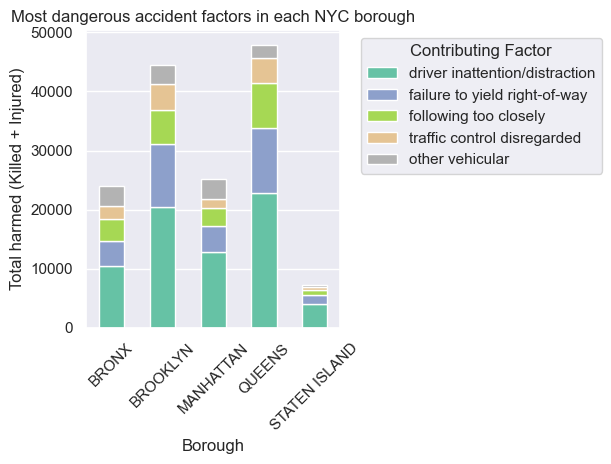

In [119]:
impact_pivot.plot(kind="bar", stacked=True, colormap="Set2")

plt.title("Most dangerous accident factors in each NYC borough", fontsize=12)
plt.xlabel("Borough", fontsize=12)
plt.xticks(rotation = 45)
plt.ylabel("Total harmed (Killed + Injured)")
plt.legend(title="Contributing Factor",bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis="x")
plt.show()

# How many deaths and injuries were caused by unsafe speed in each borough

In [120]:
df_speeding = df.copy()

In [121]:
columns = ["BOROUGH","NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED","CONTRIBUTING FACTOR VEHICLE 1",
           "CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5", "COLLISION_ID"]

In [122]:
df_speeding = df_speeding[columns]

In [123]:
df_speeding = df_speeding[~df_speeding["BOROUGH"].isin(["UNKNOWN"])]

In [124]:
df_long = df_speeding.melt(id_vars = ["COLLISION_ID","BOROUGH","NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED"],
                          value_vars = ["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3", 
               "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                         var_name="FACTOR_SOURCE",
                         value_name="CONTRIBUTING FACTOR")

In [125]:
df_long = df_long[df_long["CONTRIBUTING FACTOR"].isin(["unsafe speed"])]

In [126]:
summary = df_long.groupby(["BOROUGH"]).agg(
    total_killed = ("NUMBER OF PERSONS KILLED", "sum"),
    total_injured = ("NUMBER OF PERSONS INJURED", "sum")
).reset_index()

In [127]:
print(summary)

         BOROUGH  total_killed  total_injured
0          BRONX            18           1627
1       BROOKLYN            23           2211
2      MANHATTAN            10            750
3         QUEENS            48           2406
4  STATEN ISLAND            12            444


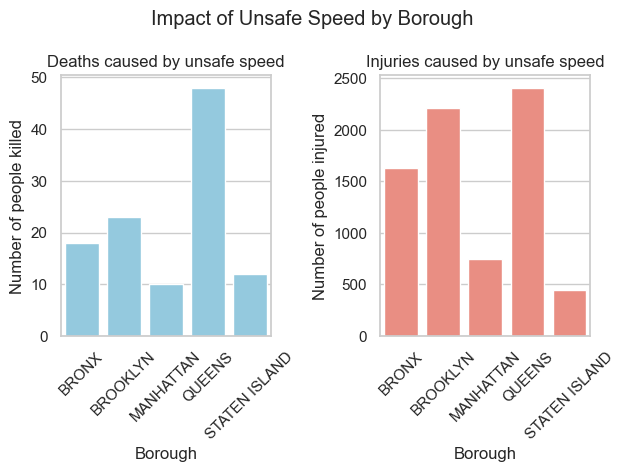

In [128]:
sns.set_style(style="whitegrid")

fig, axes = plt.subplots(1, 2)

sns.barplot(ax = axes[0], data = summary, x = "BOROUGH", y = "total_killed", color = "skyblue")
axes[0].set_title("Deaths caused by unsafe speed")
axes[0].set_xlabel("Borough")
axes[0].set_ylabel("Number of people killed")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], data=summary, x="BOROUGH", y="total_injured", color="salmon")
axes[1].set_title("Injuries caused by unsafe speed")
axes[1].set_xlabel("Borough")
axes[1].set_ylabel("Number of people injured")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Impact of Unsafe Speed by Borough")
plt.tight_layout()
plt.show()

# 3 most common accident factors broken down by borough and overall for the entire city

In [129]:
df_common_factors = df.copy()

In [130]:
columns = ["BOROUGH","CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5"]

In [131]:
df_common_factors = df_common_factors[columns]

In [132]:
df_long = df_common_factors.melt(id_vars = ["BOROUGH"],
                                value_vars = ["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3",
                                              "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                                 var_name = "FACTOR_SOURCE",
                                 value_name = "CONTRIBUTING FACTOR"
                                )

In [133]:
df_long = df_long[~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])]

In [134]:
df_borough = df_long[
    ~df_long["BOROUGH"].isin(["UNKNOWN"]) &
    ~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])
    ]

In [135]:
top_by_borough = df_borough.groupby(
    ["BOROUGH","CONTRIBUTING FACTOR"]).size().reset_index().rename(columns={0: 'count'}).sort_values(['BOROUGH', 'count'], ascending=[True, False])

In [136]:
top_3_by_borough = top_by_borough.groupby("BOROUGH").head(3)

In [137]:
pivot_borough = top_3_by_borough.pivot(index='BOROUGH', columns='CONTRIBUTING FACTOR', values='count')

In [138]:
top_3_entire = df_long["CONTRIBUTING FACTOR"].value_counts().head(3).reset_index()
top_3_entire.columns = ['CONTRIBUTING FACTOR', 'count']

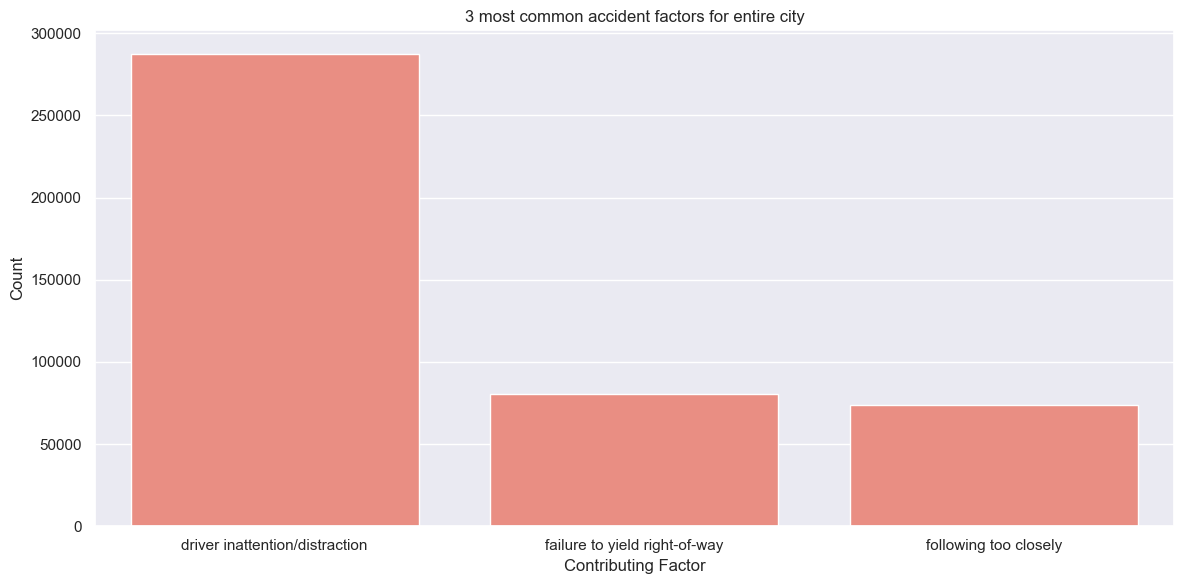

In [139]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(data = top_3_entire, x = "CONTRIBUTING FACTOR", y = "count", color = "salmon"  )
ax.set_title("3 most common accident factors for entire city")
ax.set_xlabel("Contributing Factor")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

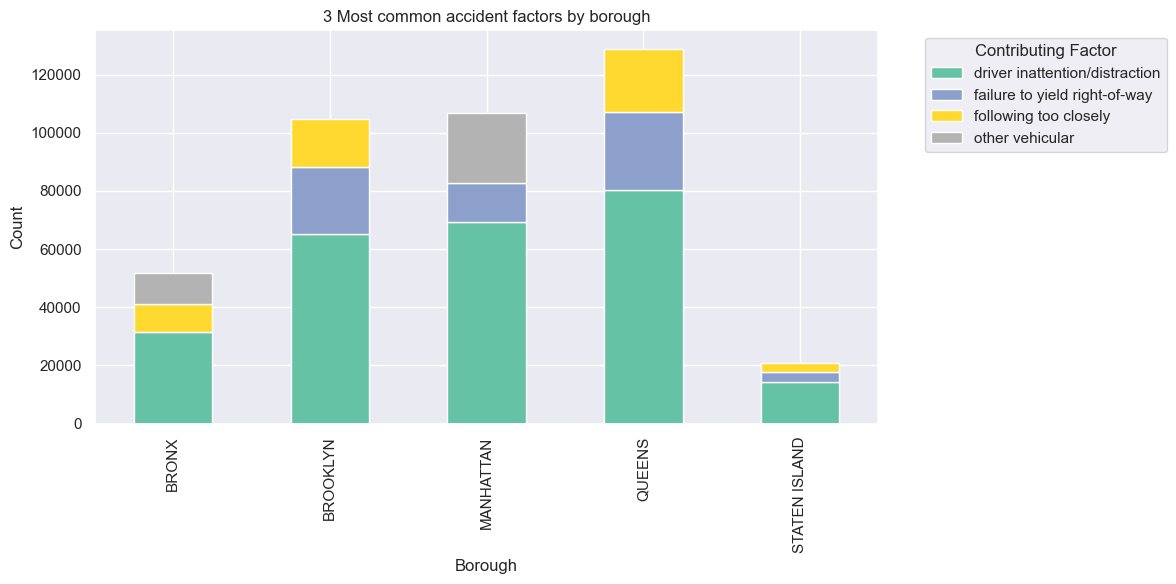

In [140]:
pivot_borough.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.title("3 Most common accident factors by borough")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.legend(title="Contributing Factor", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Most frequently vehicles types involved in accidents

In [141]:
df_vehicles = df.copy()

In [142]:
vehicle_columns = ["COLLISION_ID", "VEHICLE TYPE CODE 1","VEHICLE TYPE CODE 2","VEHICLE TYPE CODE 3","VEHICLE TYPE CODE 4","VEHICLE TYPE CODE 5"]

In [143]:
df_vehicles = df_vehicles[vehicle_columns]

In [144]:
df_long = df_vehicles.melt(id_vars = ["COLLISION_ID"],
                          value_vars = ["VEHICLE TYPE CODE 1","VEHICLE TYPE CODE 2","VEHICLE TYPE CODE 3","VEHICLE TYPE CODE 4","VEHICLE TYPE CODE 5"],
                          var_name = "TYPE_SOURCE",
                          value_name = "VEHICLE TYPE")

In [145]:
df_long = df_long[~df_long["VEHICLE TYPE"].isin(["unknown"])]

In [146]:
summary = df_long["VEHICLE TYPE"].value_counts().head(5).reset_index()
summary.columns = ["VEHICLE TYPE", "count"]

In [147]:
print(summary)

        VEHICLE TYPE   count
0  passenger vehicle  985909
1                suv  647064
2               taxi   98155
3       pickup truck   53793
4               bike   25401


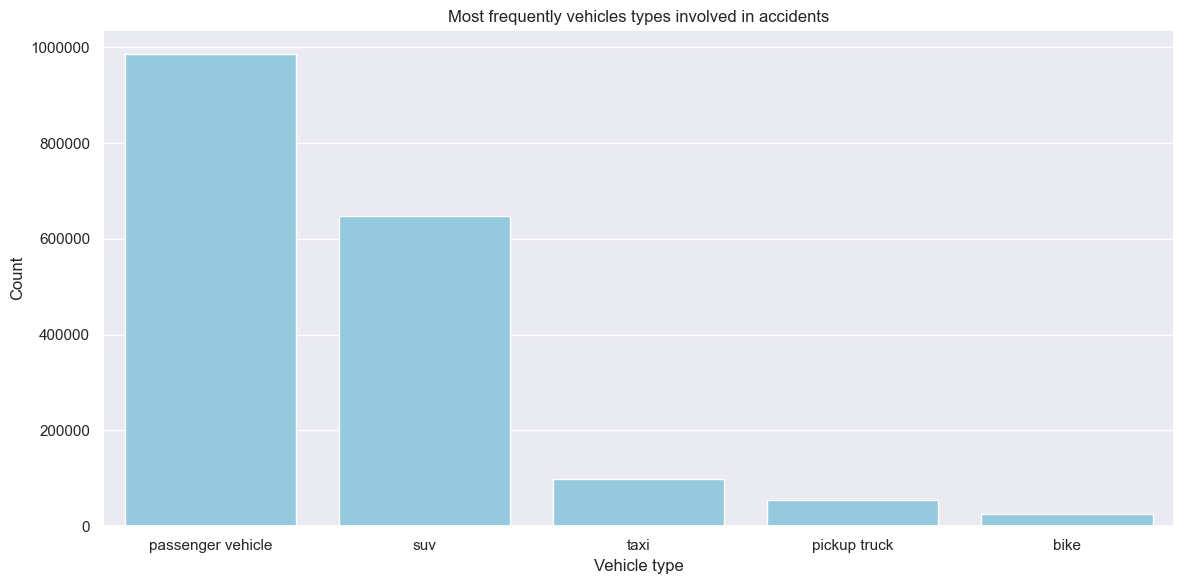

In [148]:
sns.set_style("darkgrid")
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(data = summary, x = "VEHICLE TYPE", y = "count", color = "skyblue")
ax.set_title("Most frequently vehicles types involved in accidents")
ax.set_xlabel("Vehicle type")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Statistics on the number of accidents for each borough

In [149]:
df_number = df.copy()

In [150]:
df_number.columns

Index(['ACCIDENT DATE', 'ACCIDENT TIME', 'BOROUGH', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'ACCIDENT DATE FORMATTED'],
      dtype='object')

In [151]:
columns_statisctics = ["BOROUGH", "ACCIDENT TIME", "COLLISION_ID"]

In [152]:
df_number = df_number[columns_statisctics]

In [153]:
df_number = df_number[~df_number["BOROUGH"].isin(["UNKNOWN"])]

In [170]:
df_number.duplicated().sum()

np.int64(0)

In [171]:
df_number.head()

,BOROUGH,ACCIDENT TIME,COLLISION_ID
0,QUEENS,16:30,4184637
1,BROOKLYN,16:02,4195773
2,MANHATTAN,17:57,4202457
3,BRONX,21:53,4198749
4,MANHATTAN,9:45,4183798


In [177]:
summary_statistics = df_number.groupby(["BOROUGH"]).size().reset_index(name="COUNT").sort_values(by=["COUNT"], ascending=False)

In [178]:
summary_statistics.head()

,BOROUGH,COUNT
1,BROOKLYN,321508
3,QUEENS,310050
2,MANHATTAN,246998
0,BRONX,155334
4,STATEN ISLAND,53648


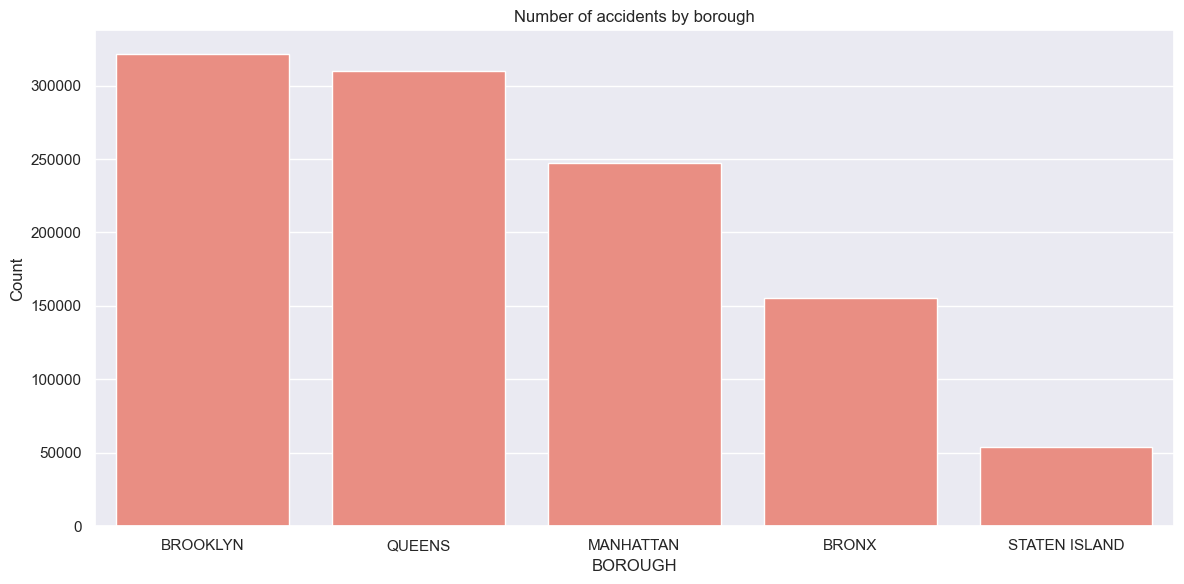

In [179]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(data = summary_statistics, x = "BOROUGH", y = "COUNT", color = "salmon")
ax.set_title("Number of accidents by borough")
ax.set_xlabel("BOROUGH")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()